In [1]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import os

np.random.seed(0) # fix seed so we don't get different predictions every time we run it

In [2]:
# define the differential equation function "de_fun(z(t))"
a, b, tau = 0.2, 0.1, 17
de_fun = lambda z,t : -b*z[t] + a * z[t-tau] / ( 1 + z[t-tau]**10)

# generate time series z
N = 8000 # the length of the time series
z = np.zeros(N) # inialize time series data
z[:tau+1] = 2*np.random.rand(tau+1)
for t in np.arange(tau+1, N):
    z[t] = z[t-1] + de_fun(z,t-1)
z[:tau+1]=z[N-2*tau:N-tau+1]    
for t in np.arange(tau+1, N):
    z[t] = z[t-1] + de_fun(z,t-1)

In [3]:
L = 16 # lag
start_train_time = 20 # start time of training data, should be greatet than lag L
n_train = 1500 # size of training data
start_test_time = start_train_time + n_train+1 # start time of test data, should be greatet than ( start_train_time + n_train )
n_test = 100 # size of test data / lead time / the number of steps ahead
data_x = np.zeros((N, L)) # input
data_y = np.zeros(N) # output


for k in np.arange(start_train_time, N):
    data_x[k,:] = z[k-L:k]
    data_y[k] = z[k]

# set up training data
train_x = data_x[start_train_time : start_train_time + n_train, :]
train_y = data_y[start_train_time : start_train_time + n_train]

train_x = torch.from_numpy(train_x).float() # (n_train, L) array
train_y = torch.from_numpy(train_y).float() # (n_train, ) array

# set up test data
test_x_start = data_x[start_test_time, :]
test_y = data_y[start_test_time : start_test_time + n_test]

test_x_start = torch.from_numpy(test_x_start).float() # (L, ) array
test_y = torch.from_numpy(test_y).float() # (n_test, ) array

In [4]:
# GP inference setting up

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [5]:
# GP training

smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    #     i + 1, training_iter, loss.item(),
    #     model.covar_module.base_kernel.lengthscale.item(),
    #     model.likelihood.noise.item()
    # ))
    optimizer.step()

In [6]:
# GP test

# get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()


Ns = 2000 # the number of samplings

# initialize predictive mean and variance 
y_mean = torch.zeros(n_test)
y_var = torch.zeros(n_test)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for i in np.arange(n_test):  
        if i == 0:
            mean_test_x = test_x_start # (L, ) array
            cov_test_x = torch.zeros(L,L) # (L, L) array
        else:
            mean_test_x = torch.hstack(( mean_test_x[1:], y_mean[i-1] )) # or mean_test_x = torch.hstack(( mean_test_x[1:], torch.mean(f_samples, axis=0) ))
            K11 = cov_test_x[1:,1:] # (L-1, L-1) array
            K12 = (1/(Ns-1)) * ( test_x_samples[:,1:] - torch.mean(test_x_samples[:,1:], axis=0) ).T \
                @ ( y_samples - torch.mean(y_samples, axis=0) ) # (L-1, Ns) @ (Ns, 1) = (L-1, 1) array
            K21 = K12.T # (1, L-1) array
            K22 = (1/(Ns-1)) * ( y_samples - torch.mean(y_samples, axis=0) ).T @ ( y_samples - torch.mean(y_samples, axis=0) ) # (1, 1) array
            #K22 = y_var[i-1].reshape(1,1) # (1, 1) array
            cov_test_x = torch.vstack(( torch.hstack((K11,K12)), torch.hstack((K21,K22)) ))

        # generate test_x samplings, test_x ~ N(mean_test_x, cov_test_x), test_x = [z_{k-L},...,z_{k-1}]
        test_x_samples = torch.from_numpy( np.random.multivariate_normal(mean=mean_test_x, cov=cov_test_x, size=Ns).astype(np.float32) ) # (Ns, L) array

        # make predictions by feeding model through likelihood
        y_preds = likelihood(model(test_x_samples)) # ( or f_preds[i] = model(mean_test_x.reshape(1,-1)).mean )
        y_mean[i] = torch.mean(y_preds.mean, axis=0) # the average of posterior means of test_x samplings
        y_var[i] = torch.mean(y_preds.variance, axis=0) # the average of posterior variances of test_x samplings
        
        # generate f samplings, y = [z_{k}], y ~ N(y_mean, y_var)
        y_distribution = MultivariateNormal(loc = y_mean[i].reshape(1), covariance_matrix=y_var[i].reshape(1,1))
        y_samples = y_distribution.sample(sample_shape=torch.Size([Ns,])) # (Ns, 1) array

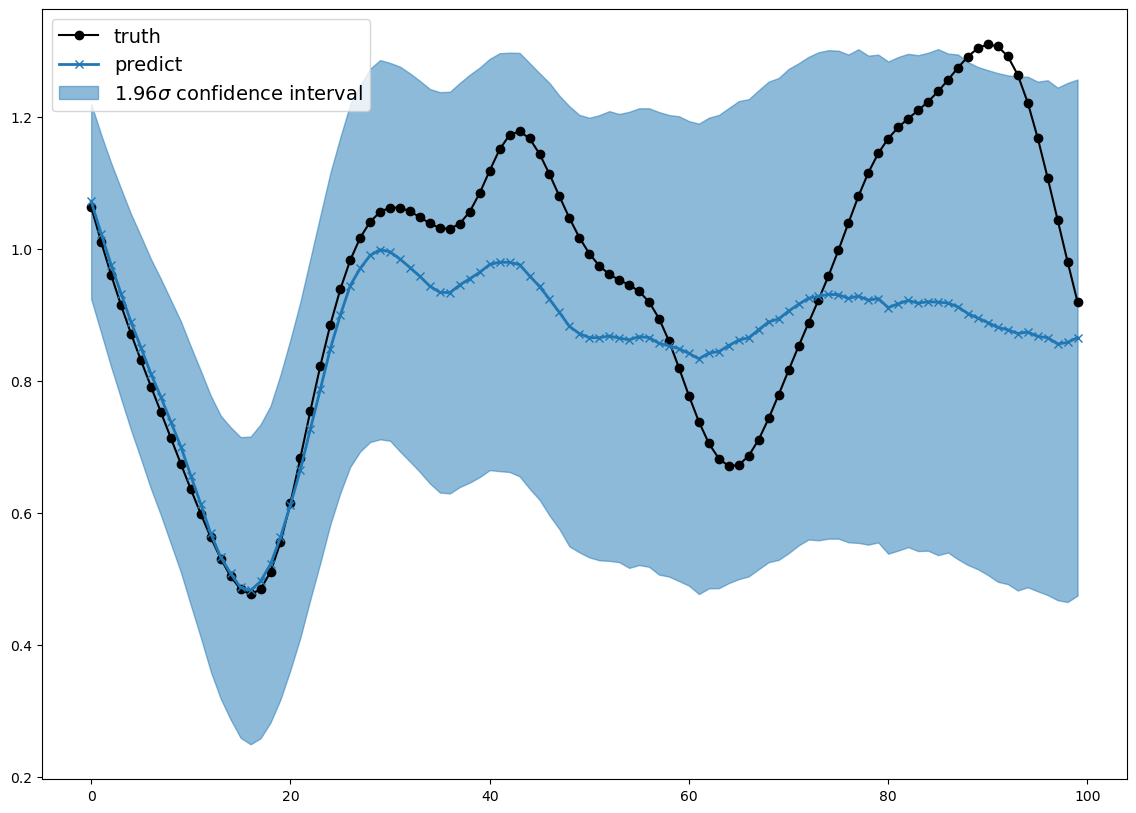

In [8]:
# plot
y_mean = y_mean.numpy() if type(y_mean) != np.ndarray else y_mean
y_var = y_var.numpy() if type(y_var) != np.ndarray else y_var

sigma_num = 1.96
lower_confs = y_mean - sigma_num*np.sqrt(y_var)
upper_confs = y_mean + sigma_num*np.sqrt(y_var)

palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
color = palette_colors[0]

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.plot(np.arange(n_test), test_y, color='black', marker='o' ) # plot true data as black stars
ax.plot(np.arange(n_test), y_mean, color, linewidth=2, marker='x') # plot predictive means as blue line
ax.fill_between(np.arange(n_test), lower_confs, upper_confs, alpha=0.5, color=color) # shade between the lower and upper confidence bounds
ax.legend(['truth', 'predict', f'${sigma_num}\sigma$ confidence interval'],fontsize=14)
plt.show()